In [1]:
import pickle
import csv
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras.utils.training_utils import multi_gpu_model
from keras.models import model_from_json
from keras import metrics
from keras import backend as K
import json
import os
import bcolz as bc
from tqdm import *
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

/home/mhassan/.conda/envs/tensorflow-py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline

Read the model file

In [3]:
def generator(x, y, batch_size):    
    while(True):
        rand_keys = np.random.choice(x.shape[0], batch_size)
        yield x[rand_keys, :, :, :, :], y[rand_keys]

In [4]:
data_path = 'data/x_train_std/'
if os.path.isdir(data_path):
    x_train = bc.open(data_path)
else:
    print('Data not found')
print('Shape of the data', x_train.shape)

Shape of the data (1338, 170, 284, 247, 8)


In [5]:
with open('data/y_train_std.pickle', 'rb') as f:
    y_train = pickle.load(f)
y_train = np.array(y_train, dtype=np.float32)

Load the non-normalized files <br>(bigger dataset, most of them are not on the training set)

In [6]:
bc_features = bc.open('data/bc_features/')
bc_features.shape

(3830, 170, 284, 247, 8)

pdb2idx = trained + untrained pdb->id dictionary

In [7]:
# with open('data/pdb2idx.pickle', 'rb') as f:
#     pdb2idx = pickle.load(f)
# len(pdb2idx)

idx2pdb is the id to pdb dictionary of the trained samples.

In [8]:
# with open('data/idx2pdb.pickle', 'rb') as f:
#     idx2pdb = pickle.load(f)
# len(idx2pdb)

In [9]:
# non_trained_ids = [_id for _id in pdb2idx.values() if _id not in idx2pdb.keys()]
# len(non_trained_ids)

In [10]:
# len(trained_pdbs)

In [11]:
with open('data/cnn_model_50.json', 'r') as f:
    loaded_model = f.read()

Load the model as a keras model

In [12]:
model = model_from_json(loaded_model)
# model = multi_gpu_model(model, gpus=4)

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 83, 140, 122, 64)  64064     
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 41, 70, 61, 64)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 39, 68, 59, 128)   221312    
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 19, 34, 29, 128)   0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 17, 32, 27, 256)   884992    
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 16, 31, 26, 256)   0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 14, 29, 24, 512)   3539456   
__________

In [14]:
model = multi_gpu_model(model, gpus=4)

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv3d_5_input (InputLayer)     (None, 170, 284, 247 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 170, 284, 247 0           conv3d_5_input[0][0]             
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 170, 284, 247 0           conv3d_5_input[0][0]             
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 170, 284, 247 0           conv3d_5_input[0][0]             
__________________________________________________________________________________________________
lambda_4 (

In [16]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[metrics.mse])

Load the weights

In [17]:
model.load_weights('data/cnn_model_50.h5')

### Evaluate the model

In [18]:
batch_size = 4
epochs = 2

In [19]:
# model.fit_generator(generator=generator(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0]//epochs, verbose=1)

In [20]:
# model.evaluate_generator(generator=generator(x_train, y_train, batch_size), max_queue_size=3, steps=3)

In [21]:
%time x_test, y_test = next(generator(x_train, y_train, batch_size))
print(y_test)

CPU times: user 4.36 s, sys: 9.28 s, total: 13.6 s
Wall time: 7.72 s
[ 6.52  3.68 11.35  3.9 ]


In [22]:
model.predict(x_test)

array([[6.5560007],
       [6.5560007],
       [6.5560007],
       [6.5560007]], dtype=float32)

In [23]:
y_test

array([ 6.52,  3.68, 11.35,  3.9 ], dtype=float32)

In [22]:
y_exp = []
y_predict = []

In [27]:
for _ in range(10):
    bx, y_ = next(generator(x_train, y_train, batch_size))
    y_p = model.predict(bx)
    y_predict = y_predict + y_p.tolist()
    y_exp = y_exp + y_.tolist()

In [28]:
len(y_exp), len(y_predict)

(40, 40)

In [29]:
r2 = r2_score(y_pred=y_predict, y_true=y_exp)

Print the $R^2$ value

In [30]:
r2

-0.01437678704912626

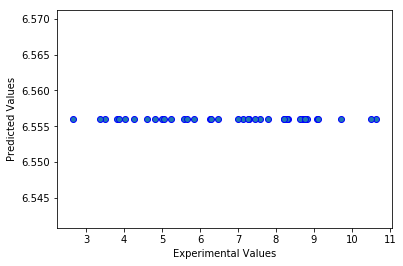

In [31]:
f = plt.figure()
plt.xlabel('Experimental Values')
plt.ylabel('Predicted Values')
plt.scatter(y_exp, y_predict, marker='o', edgecolors='b')
# plt.legend(['Binding Affinity'])
plt.show()

In [62]:
f.savefig('comparison.png')

In [28]:
# model.predict(x_test[0].reshape([-1]+list(x_test.shape[1:])))

In [58]:
# model.predict_generator(generator=generator(x_train, y_train, batch_size), steps=1)

### Training history

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
with open('data/history_50.pickle', 'rb') as f:
    history = pickle.load(f)

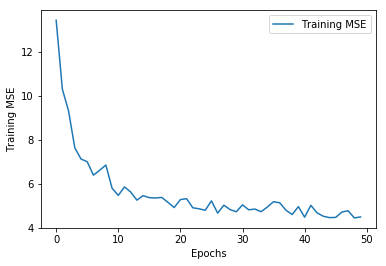

In [34]:
f2 = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Training MSE')
plt.plot(history['loss'], label='Training MSE')
plt.legend()
plt.show()

In [66]:
f2.savefig('training.png')